# GP optimizer for Objective lens

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

### Creat the machine interface

In [3]:
ndim = 1 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)

# Get the current for the other lenses
x_low = np.asarray([1000, -40, 387000, -660000, 119000, 640000])
x_high = np.asarray([2800, 40, 393000, -635000, 120300, 651000])
start_point = [1498.216 , 0.47, 390000 , -654100, 119931.5, 648691.415]
lens = [(start_point - x_low)/(x_high - x_low)]

start_point = [[0.5]]

#creat machine interface
mi_module = importlib.import_module('machine_interfaces.machine_interface_Defocus')
# mi_module = importlib.import_module('multinormal')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, lens = lens)

Using TensorFlow backend.


Model loaded


In [4]:
mi.setLens(lens)
mi.x[0]

array([0.5])

/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Predicting defocus...
saving ronchigram...


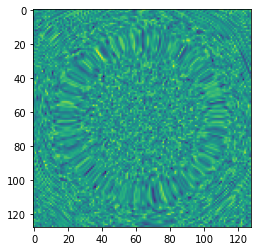

In [5]:
#check the reading objective is working
mi.getState()
temp = np.load('ronchigram.npy')
plt.imshow(temp)
plt.show()

### Create the gp

In [6]:
# hyperparameters determined using GPy for emittance from CNN

#TFGP
gp_ls = np.array(np.ones(ndim)) * [0.317] 
gp_amp = 0.256
gp_noise = 0.000253

gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
gp = OGP(ndim, hyperparams)

### Create the BO

In [7]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
optimize_kernel_on_the_fly = 2
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids,
               optimize_kernel_on_the_fly = optimize_kernel_on_the_fly)
opt.ucb_params = np.array([2, None])

Run BO w/ kernel optimization on the fly
Supposed to be grabbing initial machine state...
Predicting defocus...
saving ronchigram...
x_init [[0.5]]
y_init [[0.55352446]]


**Running BO**

*run the gp search for some number of steps*

In [8]:
Obj_state_s=[]
Obj_state_s.append(mi.getState()[1][0]) # initialize Obj_state_s list with the initial objective value

Predicting defocus...
saving ronchigram...


<Figure size 288x288 with 0 Axes>

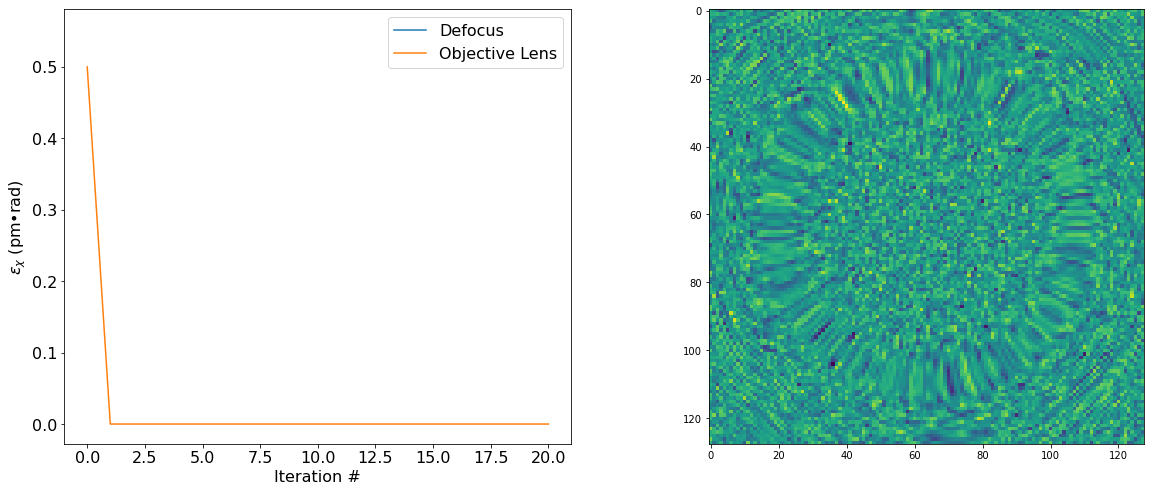

[[1.        ]
 [0.16666667]
 [0.83333333]
 [0.5       ]
 [1.16666667]
 [0.08333333]
 [0.75      ]
 [0.41666667]
 [1.08333333]
 [0.25      ]
 [0.91666667]
 [0.58333333]
 [1.25      ]
 [0.04166667]
 [0.70833333]
 [0.375     ]
 [1.04166667]
 [0.20833333]
 [0.875     ]
 [0.54166667]] 20 1
[[        inf]
 [-0.96742157]
 [ 0.96742157]
 [ 0.        ]
 [        nan]
 [-1.38299413]
 [ 0.67448975]
 [-0.21042839]
 [        nan]
 [-0.67448975]
 [ 1.38299413]
 [ 0.21042839]
 [        nan]
 [-1.7316644 ]
 [ 0.54852228]
 [-0.31863936]
 [        nan]
 [-0.8122178 ]
 [ 1.15034938]
 [ 0.10463346]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


[[        inf         nan]
 [ 0.31599642 -1.01242876]
 [ 0.68400358 -1.01242876]
 [ 0.5        -1.01242876]
 [        nan         nan]
 [ 0.23695452 -1.01242876]
 [ 0.62828795 -1.01242876]
 [ 0.45997652 -1.01242876]
 [        nan         nan]
 [ 0.37171205 -1.01242876]
 [ 0.76304548 -1.01242876]
 [ 0.54002348 -1.01242876]
 [        nan         nan]
 [ 0.17063743 -1.01242876]
 [ 0.60432894 -1.01242876]
 [ 0.43939479 -1.01242876]
 [        nan         nan]
 [ 0.34551617 -1.01242876]
 [ 0.71879645 -1.01242876]
 [ 0.51990128 -1.01242876]]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
# Test over single starting point
Niter = 20
Status_array = np.zeros([Niter + 1])
Status_array[0] = opt.current_x[0][0]

Ronch_array = []

for i in range(Niter):
    
    print ('iteration =', i)
    fig = plt.figure(figsize=(4,4))
    temp = np.load('ronchigram.npy')
    Ronch_array.append(temp)
    
    clear_output(wait=True)

    fig = plt.figure(figsize=[20,8])
    plt.subplot(121)

    plt.plot(Obj_state_s,'-',c='C0', label = 'Defocus')
    plt.plot(Status_array,c='C1', label = 'Objective Lens')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.xlabel('Iteration #', fontsize = 16)
    plt.ylabel('$\epsilon_\chi$ (pm\u2022rad)', fontsize=16)

    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    # Start of new iteration
    temp = opt.OptIter() # save the new acquisition point and objective value
    Obj_state_s.append(opt.best_seen()[1]) # save current best value
    Status_array[i] = temp[0][0][0]
    
    print(opt.best_seen())

In [25]:
len(Obj_state_list)

50

In [24]:
# test over different starting points
itest = 50

x_low = np.asarray([1000, -20, 387000, -655000, -3.7515e6, 119000, 640000])
x_high = np.asarray([2200, 20, 391000, -635000, -3.7495e6, 120300, 651000])

# Obj_state_list = []

for istart in range(len(Obj_state_list),itest):
    
    rs = np.random.RandomState()
    start_point = [x_low[i] + (rs.rand()*(x_high[i]-x_low[i])) for i in range(7)]
    lens = [(start_point - x_low)/(x_high - x_low)]
    start_point = [[np.random.RandomState().rand()]]  
    
    mi_module = importlib.import_module('machine_interfaces.machine_interface_Defocus')
    mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, lens = lens)
    
    gp_ls = np.array(np.ones(ndim)) * [0.317] 
    gp_amp = 0.256
    gp_noise = 0.000253
    gp_precisionmat =  np.array(np.diag(1/(gp_ls**2)))
    ndim = len(dev_ids)
    hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise} 
    gp = OGP(ndim, hyperparams)
    
    opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
    opt.ucb_params = np.array([2, None])
    
    Obj_state_s=[]  # initialize empty Obj_state_s for each start point
    Niter = 10  # run 10 iterations for each case
    
    for i in range(Niter):
        Obj_state_s.append(opt.best_seen()[1])
        opt.OptIter()
        
    Obj_state_list.append(Obj_state_s)
    
    print(str(istart)+' Finished.')

Model loaded
Supposed to be grabbing initial machine state...
249561.17668146358
Predicting defocus...
saving ronchigram...
x_init [[0.42686278]]
y_init [[0.54549274]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248457.1551902283
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


245873.35497987564
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251323.76287538125
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253231.79315057915
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255146.15743213415
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252431.70749111153
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252701.88254813474
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252735.5276230779
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252749.2498682747
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252752.38964122083
Predicting defocus...
saving ronchigram...
8 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247597.99003781556
Predicting defocus...
saving ronchigram...
x_init [[0.09966501]]
y_init [[0.03453833]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246493.9685465803
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250717.3053466811
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254818.62471223308
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248611.66161469047
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256423.3053466811
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259853.70393997332
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261968.67386148399
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


264248.89723240765
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260987.77658000248
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261035.16757163906
Predicting defocus...
saving ronchigram...
9 Finished.
Model loaded
Supposed to be grabbing initial machine state...
248322.9912937472
Predicting defocus...
saving ronchigram...
x_init [[0.22049855]]
y_init [[0.26938987]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247218.96980251197
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250326.2223285327
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252782.353714782
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254585.5365292214
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256612.54077233828
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253696.38127236132
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255332.41899794954
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254064.06342684894
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255033.22155196583
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254980.0200829697
Predicting defocus...
saving ronchigram...
10 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252749.62933624053
Predicting defocus...
saving ronchigram...
x_init [[0.95827156]]
y_init [[0.03048044]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251645.60784500526
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247202.84564568094
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256119.01855893154
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259730.64030099552
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262022.50634349382
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


264752.25237874576
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260850.1736345325
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260850.24194458514
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260850.24988428282
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253853.6508274758
Predicting defocus...
saving ronchigram...
11 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252475.72996645418
Predicting defocus...
saving ronchigram...
x_init [[0.91262166]]
y_init [[0.05081087]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251371.7084752189
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247319.24508612376
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255488.30915970032
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259003.77898619958
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261123.52529774528
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257602.59803007025
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259807.1347013694
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259806.18321673814
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


265512.1832167381
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259787.3873743139
Predicting defocus...
saving ronchigram...
12 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250082.87034249824
Predicting defocus...
saving ronchigram...
x_init [[0.51381172]]
y_init [[0.12810385]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248978.84885126297
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253249.60825442738
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256974.37655098934
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259131.15512845883
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260980.99852420087
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258348.65405071303
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258626.7382357903
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258676.20383795598
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258681.91034084736
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258684.2643605257
Predicting defocus...
saving ronchigram...
13 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251468.76125678702
Predicting defocus...
saving ronchigram...
x_init [[0.74479354]]
y_init [[0.26634425]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250364.73976555176
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247083.76934510394
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253882.87340526376
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256211.72446145155
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257948.28715742932
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255380.41236785578
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256089.8750478922
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256004.30447739427
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255993.1892898424
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255989.01080441455
Predicting defocus...
saving ronchigram...
14 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252716.71302009173
Predicting defocus...
saving ronchigram...
x_init [[0.9527855]]
y_init [[0.1123445]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251612.69152885646
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255745.04495642672
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258818.7265773896
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260953.16550517431
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262870.24565964966
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260113.95044567058
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260791.12897904692
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260832.30485217515
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260832.06270819035
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260828.16459922458
Predicting defocus...
saving ronchigram...
15 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252682.0074703927
Predicting defocus...
saving ronchigram...
x_init [[0.94700125]]
y_init [[0.12783176]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251577.98597915744
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247802.0597378846
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255401.6146784498
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258729.24978976644
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260760.96094686296
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262640.7262347043
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261575.6819146181
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261349.29432617992
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261252.74190184876
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261231.29068324403
Predicting defocus...
saving ronchigram...
16 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252173.96038055528
Predicting defocus...
saving ronchigram...
x_init [[0.86232673]]
y_init [[0.14457166]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251069.93888932
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254979.04060773813
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258000.11367545443
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259939.72276898095
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256885.5496720897
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262591.5496720897
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256916.2306021026
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256961.87889251765
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256979.33265542786
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256972.55890976012
Predicting defocus...
saving ronchigram...
17 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247286.54687578883
Predicting defocus...
saving ronchigram...
x_init [[0.04775781]]
y_init [[0.15438724]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246182.52538455356
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250958.17437663482
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254331.989116333
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256942.9471439924
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258859.18068327988
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255974.0078084806
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262648.9471439924
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256890.38062696668
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256823.00308226573
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256809.35497518152
Predicting defocus...
saving ronchigram...
18 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251347.20616251684
Predicting defocus...
saving ronchigram...
x_init [[0.72453436]]
y_init [[0.10488808]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250243.18467128157
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246500.70168774299
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254081.455821648
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257185.79945690662
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258844.95273458736
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256231.235626287
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257734.8592522167
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257589.7463809706
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262548.8568314747
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257556.4466070608
Predicting defocus...
saving ronchigram...
19 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249574.90935530953
Predicting defocus...
saving ronchigram...
x_init [[0.42915156]]
y_init [[0.28313625]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248470.88786407426
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251933.1943406159
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254568.34785395357
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256260.54549805648
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253642.91668438606
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254274.28951858942
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254259.4393685211
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254254.0577460435
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254251.57550506268
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254249.97665379007
Predicting defocus...
saving ronchigram...
20 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249523.39760033975
Predicting defocus...
saving ronchigram...
x_init [[0.42056627]]
y_init [[0.07624221]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248419.3761091045
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253193.08588148095
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256646.9552111361
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259700.4072784709
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261752.41859798276
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258511.6746721892
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258581.32790637852
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258603.75743569635
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258608.71516305415
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258591.5098195304
Predicting defocus...
saving ronchigram...
21 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252915.69468305993
Predicting defocus...
saving ronchigram...
x_init [[0.98594911]]
y_init [[0.70698363]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251811.67319182467
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249144.14913122114
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254607.99193078413
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256358.31205614196
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253682.05265189652
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254336.57933121573
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254341.76468648858
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254343.10571419288
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254343.44912576454
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254343.41174200783
Predicting defocus...
saving ronchigram...
22 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249884.37107794062
Predicting defocus...
saving ronchigram...
x_init [[0.48072851]]
y_init [[0.11325282]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248780.3495867054
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


244983.38574347532
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252657.7976114145
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256270.74032005467
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257972.22144795264
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255084.5778914109
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256963.1158321634
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256857.64374755014
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262533.4367825849
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256836.3043397126
Predicting defocus...
saving ronchigram...
23 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251807.90772861845
Predicting defocus...
saving ronchigram...
x_init [[0.80131795]]
y_init [[0.4522965]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250703.88623738318
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247890.55643121173
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253685.40483476274
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255419.55324125246
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254574.72424050418
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258059.1487333522
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254596.35291079787
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254613.45238327116
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254619.51731272537
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254623.73512126497
Predicting defocus...
saving ronchigram...
24 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252004.7484455706
Predicting defocus...
saving ronchigram...
x_init [[0.83412474]]
y_init [[0.9032333]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250900.72695433535
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248576.62593562
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253451.23948392138
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255155.91513817932
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252577.9139665398
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253168.52445846598
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253143.39130910696
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253136.72626257138
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253133.98306734403
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253132.2655841055
Predicting defocus...
saving ronchigram...
25 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247809.92224757848
Predicting defocus...
saving ronchigram...
x_init [[0.13498704]]
y_init [[0.21023488]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246705.9007563432
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250275.9710401229
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253624.28130667735
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256104.3731045475
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257909.4641020315
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259962.7418656526
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257053.50676263505
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257159.21291204414
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257186.9394264305
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257204.346549985
Predicting defocus...
saving ronchigram...
26 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252774.73220556404
Predicting defocus...
saving ronchigram...
x_init [[0.96245537]]
y_init [[0.31890798]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251670.71071432877
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248376.88617072566
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255045.2282027332
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257203.5323557328
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259100.97914358974
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256383.8456244221
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256519.3295579678
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256577.5327295763
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256594.53941382281
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256599.77989818162
Predicting defocus...
saving ronchigram...
27 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249976.93763208477
Predicting defocus...
saving ronchigram...
x_init [[0.49615627]]
y_init [[0.12840414]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248872.9161408495
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252870.3481064069
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


244839.8838539382
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255682.93763208477
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258619.96707057825
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261388.93763208477
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257102.9575401527
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251080.95912332003
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257097.7756454703
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262803.7756454703
Predicting defocus...
saving ronchigram...
28 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249784.18903812376
Predicting defocus...
saving ronchigram...
x_init [[0.46403151]]
y_init [[0.23012364]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248680.1675468885
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252376.5567414836
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255375.1761295656
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257161.86211366052
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254335.7132451738
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255852.58484137995
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255812.16536037304
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255792.14365452933
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261558.58484137995
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255775.94190029957
Predicting defocus...
saving ronchigram...
29 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250606.44316190027
Predicting defocus...
saving ronchigram...
x_init [[0.60107386]]
y_init [[0.23182303]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249502.421670665
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246130.25345158263
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252962.6104305003
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255662.2535422341
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257691.57911813466
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259519.0747882053
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256907.99280838214
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257315.63199871988
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257323.88341866844
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257325.83613820284
Predicting defocus...
saving ronchigram...
30 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247337.0667947566
Predicting defocus...
saving ronchigram...
x_init [[0.0561778]]
y_init [[0.10721844]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246233.04530352133
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


242543.96657525245
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250070.7923762849
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253793.18817580998
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256019.12260395556
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257766.22036847513
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255201.83852882072
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255715.96584259605
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255701.77319206137
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255696.25078272988
Predicting defocus...
saving ronchigram...
31 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249424.9842187331
Predicting defocus...
saving ronchigram...
x_init [[0.40416404]]
y_init [[0.12275082]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248320.96272749783
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252467.23950831027
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255130.9842187331
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258902.3406353323
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261235.06827466103
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


263215.793020506
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260333.49235712056
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260484.1684170937
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260475.01937309714
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260477.22535296055
Predicting defocus...
saving ronchigram...
32 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251902.16453069277
Predicting defocus...
saving ronchigram...
x_init [[0.81702742]]
y_init [[0.04845649]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250798.14303945753
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246745.7774765106
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254936.75861668168
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258917.3815023914
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262144.92771721433
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


264350.3419682892
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260830.68555014703
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


266536.685550147
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253006.18602192804
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261328.39827797568
Predicting defocus...
saving ronchigram...
33 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251361.6749323076
Predicting defocus...
saving ronchigram...
x_init [[0.72694582]]
y_init [[0.27930462]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250257.65344107233
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253670.30788066704
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256103.36186278478
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258397.01379879127
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255023.76184118117
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255479.11920659873
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255506.49073986293
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256765.34556828105
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254998.86229479124
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255655.2869831329
Predicting defocus...
saving ronchigram...
34 Finished.
Model loaded
Supposed to be grabbing initial machine state...
248687.9399106114
Predicting defocus...
saving ronchigram...
x_init [[0.28132332]]
y_init [[0.07594341]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247583.91841937616
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251965.55864574845
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255299.87824081667
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249884.52719567416
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257671.55864574845
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260856.54832809267
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262573.7394816626
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259848.57077098748
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260424.37488943455
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260419.697524775
Predicting defocus...
saving ronchigram...
35 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250607.63330047246
Predicting defocus...
saving ronchigram...
x_init [[0.60127222]]
y_init [[0.43036926]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249503.6118092372
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246587.78456112728
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252772.20468814444
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254489.55829522084
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253676.10637369775
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256953.08993369353
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253796.79091020953
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253839.1284009222
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253855.64007714056
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253894.13223210236
Predicting defocus...
saving ronchigram...
36 Finished.
Model loaded
Supposed to be grabbing initial machine state...
248475.21223007154
Predicting defocus...
saving ronchigram...
x_init [[0.24586871]]
y_init [[0.45778543]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


247371.19073883627
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


244548.78693253282
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250356.4664003349
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252136.44208096882
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254110.46174257534
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251327.76253541882
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251701.2222667725
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251707.6187434202
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251709.15192715556
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251709.2940074664
Predicting defocus...
saving ronchigram...
37 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250047.53673223266
Predicting defocus...
saving ronchigram...
x_init [[0.50792279]]
y_init [[0.12661797]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248943.5152409974
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253086.17664013302
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256536.34520226516
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259928.49954554328
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262302.1708579388
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258490.01800652785
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251151.5582234679
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260723.5688284399
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259341.28520253973
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259342.21665282105
Predicting defocus...
saving ronchigram...
38 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247288.37158906297
Predicting defocus...
saving ronchigram...
x_init [[0.04806193]]
y_init [[0.26308024]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246184.3500978277
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


242960.79677896976
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249574.425548378
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252136.22693506407
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253885.8038855615
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252884.26141303455
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252641.25362248422
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252588.56937654802
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252557.1924151359
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252552.4928063422
Predicting defocus...
saving ronchigram...
39 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251563.33142728917
Predicting defocus...
saving ronchigram...
x_init [[0.76055524]]
y_init [[0.26024604]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250459.3099360539
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253786.0402149789
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256472.45610766285
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258252.153025477
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257194.48309643022
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255667.5515451313
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255744.14208852153
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255800.47957666483
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255822.9172349289
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255827.4269490535
Predicting defocus...
saving ronchigram...
40 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250966.38833721058
Predicting defocus...
saving ronchigram...
x_init [[0.66106472]]
y_init [[0.11004639]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249862.3668459753
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253932.0462149568
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257031.44270395068
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258770.07780904384
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257912.9107704242
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257896.57722153066
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257894.12695728452
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257892.7065651487
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257891.83305678144
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257891.39801668935
Predicting defocus...
saving ronchigram...
41 Finished.
Model loaded
Supposed to be grabbing initial machine state...
250547.72614674055
Predicting defocus...
saving ronchigram...
x_init [[0.59128769]]
y_init [[0.12783062]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


249443.7046555053
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253776.0288621591
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256838.83789494535
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258551.5843440576
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255810.31950816198
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257212.44763948285
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257187.0451777597
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257177.3874762136
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262893.04517775966
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257163.27727628345
Predicting defocus...
saving ronchigram...
42 Finished.
Model loaded
Supposed to be grabbing initial machine state...
251222.84968818977
Predicting defocus...
saving ronchigram...
x_init [[0.70380828]]
y_init [[0.14028919]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250118.8281969545
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253736.7773698669
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


257416.19530165527
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259852.05520123758
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261631.07431231675
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260555.18887829172
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259141.9605483458
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259250.43318532413
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259270.18737414223
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259290.32673760853
Predicting defocus...
saving ronchigram...
43 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247144.69548420448
Predicting defocus...
saving ronchigram...
x_init [[0.02411591]]
y_init [[0.0909605]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246040.6739929692
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250521.70320914313
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253949.57412840895
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256814.95882677112
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259200.7006807005
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262520.9588267711
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255559.60873702422
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248248.71697543975
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255825.14680295487
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255688.17446106017
Predicting defocus...
saving ronchigram...
44 Finished.
Model loaded
Supposed to be grabbing initial machine state...
247359.5836085083
Predicting defocus...
saving ronchigram...
x_init [[0.0599306]]
y_init [[0.11385638]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246255.56211727305
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251095.15429405053
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


253065.5836085083
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256869.9440785888
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259374.13899385853
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


261095.9170526557
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258480.82235994103
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259063.1053390861
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259049.52398749645
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259043.07111535224
Predicting defocus...
saving ronchigram...
45 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249478.49052024275
Predicting defocus...
saving ronchigram...
x_init [[0.41308175]]
y_init [[0.18931204]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248374.46902900748
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


252041.02611974982
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254666.55031817465
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256439.1032732311
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255474.85981871915
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255358.06005305715
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255328.68006620518
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255312.3370285425
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255309.06497891384
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255298.43147209944
Predicting defocus...
saving ronchigram...
46 Finished.
Model loaded
Supposed to be grabbing initial machine state...
252220.74874545168
Predicting defocus...
saving ronchigram...
x_init [[0.87012479]]
y_init [[0.26800758]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


251116.7272542164
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254156.8729926069
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256847.83148284268
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258576.64442723914
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255904.5838773867
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256433.86584865567
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256426.17311858948
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256423.53189611592
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256422.38679908152
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256421.85196925778
Predicting defocus...
saving ronchigram...
47 Finished.
Model loaded
Supposed to be grabbing initial machine state...
249504.45011883508
Predicting defocus...
saving ronchigram...
x_init [[0.41740835]]
y_init [[0.12675565]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


248400.42862759985
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


255210.45011883508
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258568.74056155607
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260788.57898237184
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


262947.1259873442
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


259833.24474062023
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250608.47161007035
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260500.44992819725
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260304.99280303024
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


260991.90232637097
Predicting defocus...
saving ronchigram...
48 Finished.
Model loaded
Supposed to be grabbing initial machine state...
248060.57698468765
Predicting defocus...
saving ronchigram...
x_init [[0.17676283]]
y_init [[0.09488541]]


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


246956.55549345238
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


242979.64964882046
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


250985.18235629352
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


254911.1095057766
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256993.82718912693
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


258793.98854289696
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256197.85482846122
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256654.72005486346
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256651.2832397108
Predicting defocus...
saving ronchigram...


/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq
/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/modules/OnlineGP.py:464: RuntimeWarning: invalid value encountered in add
  K = K + x1_sum_sq + x2_sum_sq


256649.92552259564
Predicting defocus...
saving ronchigram...
49 Finished.


In [27]:
np.save('DefocusGP_linescansx33.npy', Obj_state_list)

In [28]:
# Plot the emittance change for each step
print(Obj_state_s)
print(np.amax(emit_list))
plt.plot(Obj_state_s)
plt.axhline(y=np.amax(emit_list),c='r')

[array([[0.09488541]]), array([[0.11440057]]), array([[0.11440057]]), array([[0.13265043]]), array([[0.67652422]]), array([[0.97958827]]), array([[0.97958827]]), array([[0.97958827]]), array([[0.98789643]]), array([[0.98839103]])]


NameError: name 'emit_list' is not defined

In [29]:
linescans = np.load('DefocusGP_linescansx33.npy')
linescans = np.squeeze(linescans)
print(linescans.shape)

(50, 10)


Text(0, 0.5, 'Defocus (nm)')

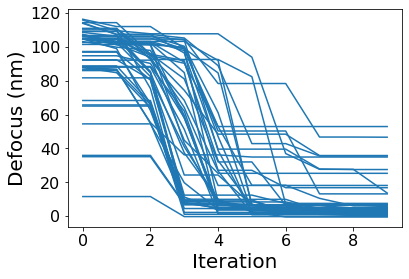

In [30]:
fig = plt.figure(figsize=[6,4])


for i in range(linescans.shape[0]):
    plt.plot((1-linescans[i,:]) * 119.987, c='C0')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Defocus (nm)',fontsize=20,rotation=90)

In [31]:
(1-linescans[:,-1]) * 119.987

array([-0.41261136,  5.568832  , 16.84495094,  2.25369675,  4.84726229,
        1.77356786,  4.2221375 ,  4.91385612,  1.44429846, 13.71386659,
        4.73557022, 13.18906789, 27.57151618,  4.41712727,  1.25305622,
        3.47488797,  4.24218797,  6.72983092, 18.17287604,  2.01842456,
        1.1499959 ,  6.44370956,  1.44475148,  3.63600378,  3.34670725,
       -0.22302387,  2.07349865,  2.63450369, 46.66214114,  7.57389055,
        1.43770094,  0.84194784,  6.10506729, 35.57405329, 34.95753388,
        6.65333367,  2.53948421,  0.46754197, 52.96045496,  3.46836555,
        1.57470674,  2.75769448,  2.79040115,  0.53103773, 35.83737835,
        2.365733  ,  3.73764513,  4.54113069, 25.33597982,  1.39292564])

## Peform linescans
This is currently a linescan with varying S2 lens current and other lenses fixed.
Would be better to run multiple random tests with other lens varying too.

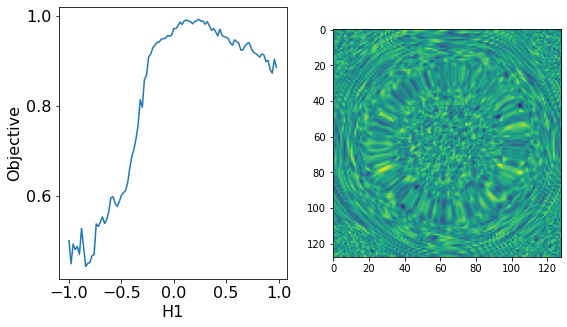

In [9]:
S2_list = []
Defocus_list = []

for i in range(100):
    mi.setX([[i/50-1]])
    temp = mi.getState()
    S2_list.append(i/50-1)
    Defocus_list.append(temp[1][0][0])
    clear_output(wait=True)
    
    fig = plt.figure(figsize = [9,5])
    
    plt.subplot(121)
    plt.plot(S2_list, Defocus_list)
    plt.xlabel('H1', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
    
    temp = np.load('ronchigram.npy')
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    

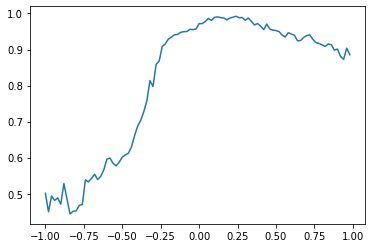

In [10]:
# Linescan with varying S7 lens
plt.plot(S2_list, Defocus_list)

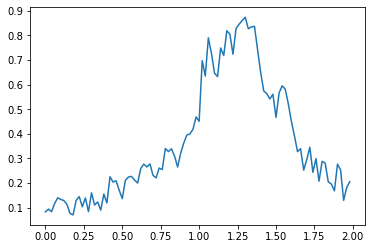

In [18]:
# Linescan with varying S2 lens
plt.plot(S2_list, Defocus_list)

In [19]:
np.save('Defocus_linescan.npy', Defocus_list)
np.save('S2_linescan.npy', S2_list)